In [ ]:
import os
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera.pandas as pa
import yfinance as yf

In [3]:
def create_yfinance_schema(ticker: str) -> pa.DataFrameSchema:
    schema = pa.DataFrameSchema(
        {
            "Close": pa.Column(pa.Float64),
            "High": pa.Column(pa.Float64),
            "Low": pa.Column(pa.Float64),
            "Open": pa.Column(pa.Float64),
            "Volume": pa.Column(pa.Int64, nullable=True),
        },
        index=pa.Index(pa.DateTime),
        strict=True,
        coerce=True,
    )

    return schema


def load_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    schema = create_yfinance_schema(ticker)

    os.makedirs("./data", exist_ok=True)
    path_name = f"./data/{ticker}-{start}to{end}.parquet"

    df: pd.DataFrame
    if os.path.exists(path_name):
        print("Loading from cache")
        df = pd.read_parquet(path_name)
    else:
        df = cast(
            pd.DataFrame,
            yf.download(ticker, start=start, end=end, multi_level_index=False),
        )

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)  # flatten index

        df.index = pd.to_datetime(df.index).tz_localize(None)
        if df.empty:
            raise ValueError(
                f"No data returned for {ticker} between {start} and {end}."
            )
        df = schema.validate(df)
        df.to_parquet(path_name)

    return df

In [22]:
msft = load_yfinance(ticker="MSFT", start="2010-01-01", end="2025-01-01")
msft.dropna(inplace=True)

/var/folders/q4/fjrsy3g95f966vyf1slqp35m0000gn/T/ipykernel_46651/3200394024.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker, start=start, end=end, multi_level_index=False),
[*********************100%***********************]  1 of 1 completed


In [23]:
sp500 = load_yfinance(ticker="^GSPC", start="2010-01-01", end="2025-01-01")
sp500.dropna(inplace=True)

/var/folders/q4/fjrsy3g95f966vyf1slqp35m0000gn/T/ipykernel_46651/3200394024.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(ticker, start=start, end=end, multi_level_index=False),
[*********************100%***********************]  1 of 1 completed


In [24]:
msft_returns = np.log(msft["Close"] / msft["Close"].shift(1))[1:]
sp500_returns = np.log(sp500["Close"] / sp500["Close"].shift(1))[1:]

In [25]:
beta = np.cov(msft_returns, sp500_returns)[0, 1] / np.var(sp500_returns)

In [26]:
print(beta)

1.1211755767324754


In [27]:
def calculate_rolling_betas(
    stock_returns: np.ndarray, market_returns: np.ndarray, window: int
) -> np.ndarray:
    rolling_betas = []

    for i in range(window, len(stock_returns)):
        beta = np.cov(stock_returns[i - window : i], market_returns[i - window : i])[
            0, 1
        ] / np.var(market_returns[i - window : i])
        rolling_betas.append(beta)
    return np.array(rolling_betas)

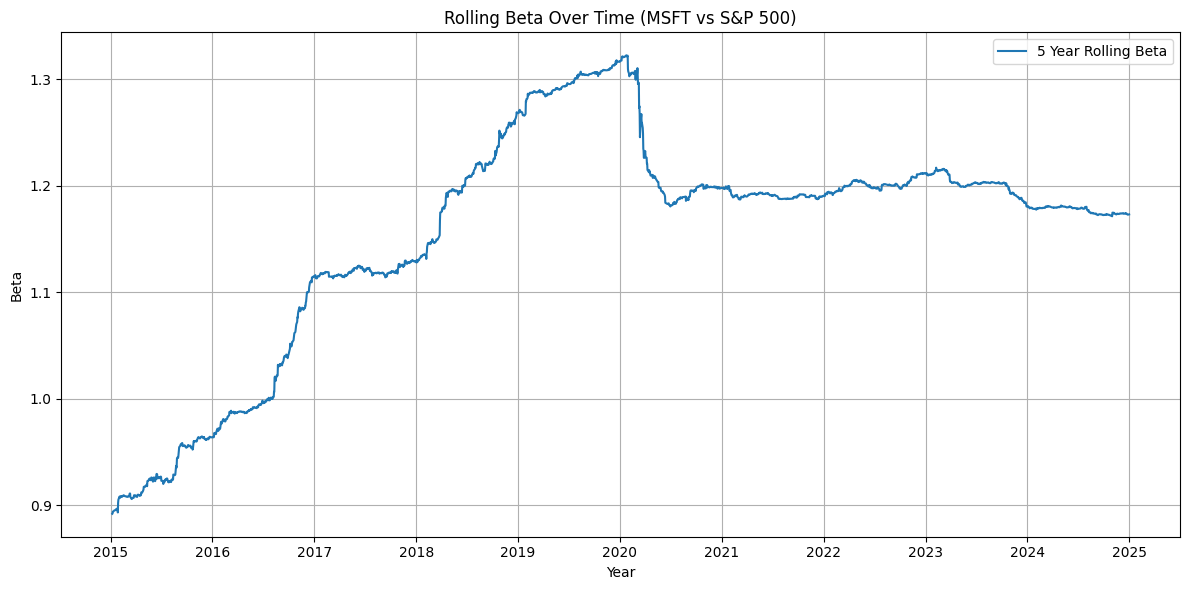

In [ ]:
window = 5 * 252
betas = calculate_rolling_betas(
    stock_returns=msft_returns, market_returns=sp500_returns, window=window
)
date_index = msft.index[1:][window:]

plt.figure(figsize=(12, 6))
plt.plot(date_index, betas, label="5 Year Rolling Beta")
plt.xlabel("Year")
plt.ylabel("Beta")
plt.title("Rolling Beta Over Time (MSFT vs S&P 500)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()